# Plots and analysis results for the DSQ Audience Stillness paper
These are the final version of data and graphs. All earlier version were on preliminary data sets. 

The stillness points used in this analysis were evaluated December 9th to 11th, 2022. This third and final review of stilling points in the concert was to ensure tags were applied consistently. A few points were added to the previous sample and a couple removed, and some cue times were renegociated with reference to the first evaluation, again with the goal of ensuring consistency in stilling point criteria. These adjustments were conducted without any reference to the actual audience motion measurements at those specific moments. Additions were specifically of points that matched in tags and/or musical content to other points already in the set, the couple of removals were of points that no longer appeared to meet the explicit criteria. These changes raised the total number of stilling points from 249 to 257. At this time, we still do not presume these selections of stilling points are complete or indisputable. They are a sufficient collection to demonstrate an interesting patterns, but still far from the whole story. 




In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import pingouin as pg

from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size

In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [3]:
%reload_ext autoreload

In [4]:
# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / (fs/2)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Load motion files

In [5]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
concert_times = pd.read_csv(public_time +'Events_Main.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [7]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Events_Full.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)


In [81]:
#In hall participants
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A']),:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
#alignedParts

In [11]:
# Online participants
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['B']),:] # virtual participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

,Participant_Code,Participant_Number,Attendance,Questionnaire_Language,Motion_Quality,Link_Conflicts,Seat_Zone,Location,Longitude_Truncated,Lattitude_Truncated,Offset_1,Offset_2,Watch_Alone
0,BDQ092,92,B,D,Q,0,NaN,Oslo,60.0,11.0,NaN,-14.36,1.0
1,BDQ093,93,B,D,Q,0,NaN,København,56.0,13.0,-7.28,NaN,1.0
2,BEQ095,95,B,E,Q,0,NaN,Horsens Danmark,56.0,10.0,-10.42,-10.68,1.0
3,BEQ096,96,B,E,Q,0,NaN,Randers sv denmark,56.0,10.0,-35.02,-35.62,1.0
4,BEQ097,97,B,E,Q,0,NaN,Moscow Russia,56.0,37.0,-11.64,-11.70,0.0
5,BEQ098,98,B,E,Q,0,NaN,Oslo,60.0,11.0,-14.62,-12.92,1.0
6,BEQ099,99,B,E,Q,0,NaN,Oxford UK,52.0,-1.0,-35.30,-36.12,1.0
7,BEQ100,100,B,E,Q,0,NaN,Bucharest,44.0,26.0,NaN,-9.68,0.0
8,BEQ101,101,B,E,Q,0,NaN,Moscow Russia,56.0,37.0,-11.88,-11.92,0.0
9,BEQ102,102,B,E,Q,0,NaN,Skærbæk,56.0,10.0,-31.24,-26.94,0.0


In [82]:
tic = time.time()
# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
        aud_df[part] = b.copy()*6 
    else:
        aud_df[part] = b.copy()
        
aud_df.index = dt_ct

print(time.time()-tic)

78.79753303527832


In [83]:
Event_ranges = {'Beethoven 1':[8,9],'Beethoven 2':[9,10],'Beethoven 3':[10,11],'Beethoven 4':[11,12],'Schnittke 1':[17,18],'Schnittke 2':[18,19],'Schnittke 3':[19,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
Seg_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29],'Folk':[33,51]}

aud_df.index = (ts_ct/1000).round(1)

seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[51,0]
[seg_start,seg_end ]


[57.4, 8042.24]

In [84]:
seg_df = aud_df.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)

# Load Stilling points
and audio features

In [15]:
# 'Low_Stillings_with_Audio.csv' Stilling_Points-reTagged_flip.csv  'ReTagged_Stillings_with_Audio.csv'
Stillings = pd.read_csv('./data/' + 'ReTagged_Stillings_with_Audio.csv')
Stillings=Stillings.fillna(0)
Stillings= Stillings.set_index('TIME')
# add music column
Stillings['Music'] = 'Music'
for ev in Seg_ranges.keys():
    seg_start = Main_concert_times.iloc[Seg_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Seg_ranges[ev][1],0]
    Stillings.loc[seg_start:seg_end,'Music'] = ev

seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[51,0]
[seg_start,seg_end ]
Still_times  = Stillings.loc[seg_start:seg_end].copy()
print(len(Still_times))
print(Stillings.columns)
Still_times.iloc[:5,:]

257
Index(['LABEL', 'Set', 'Movement', 'cues', 'Type', 'Gap', 'Rest', 'Connect',
       'Voices_dec', 'Note_rate_dec', 'Drone', 'TextInc', 'Phr_end',
       'Phr_begining', 'Elide', 'Sequence', 'Rubato', 'Rit', 'Fermata',
       'Tempo_inc', 'Diminuendo', 'Fp/Fz', 'Cresc', 'Precision', 'end',
       'OLDTIME', 'Ratio', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
       'OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift', 'QoMmean_pre',
       'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post',
       'QoMmedian_shift', 'Music'],
      dtype='object')


,LABEL,Set,Movement,cues,Type,Gap,Rest,Connect,Voices_dec,Note_rate_dec,...,OnsetRate_pre,OnsetRate_post,OnsetRate_shift,QoMmean_pre,QoMmean_post,QoMmean_shift,QoMmedian_pre,QoMmedian_post,QoMmedian_shift,Music
TIME,,,,,,,,,,,,,,,,,,,,,
61.32,2.50,1,1,3.0,pause,1.0,1.0,0.0,1.0,0.0,...,0.184,0.092,-0.092,0.089556,0.103701,0.014145,0.065307,0.074387,0.009080,Beethoven
65.84,4.50,1,1,3.0,pause,1.0,1.0,0.0,0.0,0.0,...,0.228,0.180,-0.048,0.093719,0.076082,-0.017637,0.065231,0.059797,-0.005434,Beethoven
79.02,10.25,1,1,3.0,pause,1.0,1.0,0.0,0.0,0.0,...,0.488,0.108,-0.380,0.095983,0.083841,-0.012141,0.071701,0.066467,-0.005234,Beethoven
88.75,13.00,1,1,3.0,close,0.0,0.0,1.0,0.0,0.0,...,0.172,0.164,-0.008,0.084274,0.074686,-0.009588,0.067403,0.066040,-0.001363,Beethoven
95.79,17.50,1,1,4.0,dropin,0.0,0.0,1.0,1.0,0.0,...,0.500,0.388,-0.112,0.071273,0.082875,0.011602,0.062129,0.066634,0.004504,Beethoven


In [16]:
# audio features
SoundAmp = pd.read_csv(general_loc + 'Stimuli/' + 'amplitude_env.csv')
# amplitude envelope output of sonic visualiser feature. Goodluck finding out which

SoundAmp = SoundAmp.set_index('TIME')

ts_ft = np.arange(0,8942, 0.1)#*1000 
reSound = pd.DataFrame(index = ts_ft)
f = interpolate.interp1d(SoundAmp.index, SoundAmp.VALUE,fill_value='extrapolate')
reSound['SoundAmp'] = f(ts_ft)/0.25

In [195]:
Event_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
mov_df = pd.DataFrame(columns = seg_df.columns,index=Event_ranges.keys())
seg_df = aud_df.copy()
mus_df = pd.DataFrame(columns = seg_df.columns)

#seg_df = seg_df.fillna(0)
for ev in Event_ranges:
#     print(ev)
    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    mov_df.loc[ev,:] = seg_df.loc[seg_start:seg_end,:].copy().mean(skipna=True)
    mus_df  = pd.concat([mus_df,seg_df.loc[seg_start:seg_end,:].copy()])
music_index = mus_df.index
# mov_df


In [196]:
#Main_concert_times 

# Figures
### Introduction

- Example excerpt of sound pressure level and median QoM

### Methodes
- Full concert motion recording and stilling points across pieces
    - stats: report counts of points per section of concert
- Example movement decrease calculation: Sound pressure level over indvidiual motion with intervals of comparison marked, lines connecting mean values per participant in pre and still onset with box plots and resultant ratio. Find moment with two instances to show? plot of decreasing ratios across all music and two points marked on distribution?

### Analysis 1 In Hall Audience Stilling
- Distribution of decreases across all music and across stilling points 
- Still vs stiller points 
- Median median time series at these stiller points, timing argument across all points 

### Analysis 2 
- stiller vs less still points per tag/feature
- mQoM pre and at still points for all stilling, stiller, and less still points
    - What proportion of music listening is under this threshold?
    - Plot with shading over intervals of extremely low movement.
- Full concert motion with stiller points and min motion points. 

### Analysis 3 
- Stilling participation rates: Distribution across participants per section
    - Correlations across participants per section


### Analysis 4 Virtual audience
- Distribution of decreases across all music and across stilling points for VIRTUAL AUDIENCE


## Intro and Methods

### Introduction

- Example excerpt of sound pressure level and median QoM

### Methodes
- Full concert motion recording and stilling points across pieces
    - stats: report counts of points per section of concert
- Example movement decrease calculation: Sound pressure level over indvidiual motion with intervals of comparison marked, lines connecting mean values per participant in pre and still onset with box plots and resultant ratio. Find moment with two instances to show? plot of decreasing ratios across all music and two points marked on distribution?

TODO:
- chose a better excerpt and add interval colouring to the QoM plot
- Add lines from pre to post for each participant, may be coloured by direction
- Make sure Stilling points are named in the excerpt


In [20]:
seg_tag = 'Folk 1'
seg_start = 6614.83+5 #Main_concert_times.iloc[33,0]
seg_end = seg_start+5 + 120 # Main_concert_times.iloc[34,0]
seg_qom = seg_df.loc[seg_start:seg_end].copy()
Still_times  = Stillings.loc[seg_start:seg_end].copy()
seg_sound = reSound.loc[seg_start:seg_end].copy()
[seg_start,seg_end ]

[6619.83, 6744.83]

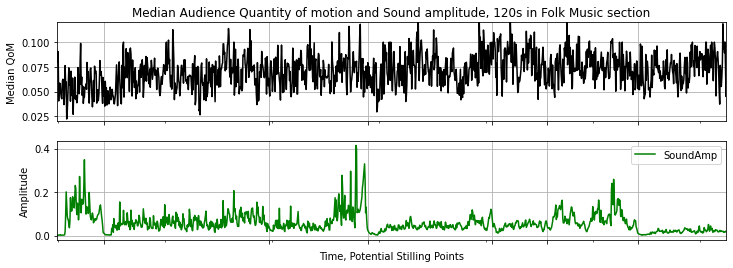

In [21]:
fig, (ax1,ax2) = plt.subplots(2, 1,sharex = True,figsize = [12,4])
seg_df.median(axis=1).plot(ax=ax1,label='Median',color='k')
#ax1.set_xticks(Still_times.index)
#ax1.set_xticklabels(Still_times.LABEL, rotation='45',fontsize=8, ha='right')
#ax1.set_xlim([seg_start,seg_end])
ax1.set_title('Median Audience Quantity of motion and Sound amplitude, 120s in Folk Music section')
ax1.set_ylim([0.02,0.12])
ax1.set_ylabel('Median QoM')
ax1.grid()

seg_sound.plot(ax=ax2,color='g')
ax2.set_xticks(Still_times.index)
a = ax2.get_xticklabels()
ax2.set_xticklabels(a,rotation='45',fontsize=8, ha='right')
ax2.set_xlim([seg_start,seg_end])
ax2.set_xlabel('Time, Potential Stilling Points')
ax2.set_ylabel('Amplitude')
ax2.grid()

plt.savefig('./Stillness_Plots/V_mQoM_Sound_excerpt.png',dpi = 300)
#plt.savefig('./Stillness_Plots/mQoM_Sound_excerpt.png',dpi = 300)
plt.show()

In [22]:
# There is some correlation between the sound amplitude and median quantity of motion
# but this is not terribly informative. We can do better.

seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[12,0]
seg_qom = seg_df.loc[seg_start:seg_end].copy()
seg_sound = reSound.loc[seg_start:seg_end].copy()
print(np.corrcoef(seg_sound['SoundAmp'], seg_qom.median(axis=1)))

seg_start = Main_concert_times.iloc[17,0]
seg_end = Main_concert_times.iloc[20,0]
seg_qom = seg_df.loc[seg_start:seg_end].copy()
seg_sound = reSound.loc[seg_start:seg_end].copy()
print(np.corrcoef(seg_sound['SoundAmp'], seg_qom.median(axis=1)))

seg_start = Main_concert_times.iloc[28,0]
seg_end = Main_concert_times.iloc[29,0]
seg_qom = seg_df.loc[seg_start:seg_end].copy()
seg_sound = reSound.loc[seg_start:seg_end].copy()
print(np.corrcoef(seg_sound['SoundAmp'], seg_qom.median(axis=1)))

# music_index 
# seg_qom = seg_df.loc[music_index,:].copy()
# seg_sound = reSound.loc[music_index,:].copy() # indexing grr
# print(np.corrcoef(seg_sound['SoundAmp'], seg_qom.median(axis=1)))

[[1.         0.13568522]
 [0.13568522 1.        ]]
[[1.         0.04367433]
 [0.04367433 1.        ]]
[[1.         0.07956098]
 [0.07956098 1.        ]]


In [23]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[53,0]
seg_times = Main_concert_times.loc[Main_concert_times['Event_Type'].isin(['Music']),:]
[seg_start,seg_end ]
seg_df = aud_df.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)
Still_times  = Stillings.loc[seg_start:seg_end].copy()


Example movement decrease calculation: 

Sound pressure level over indvidiual motion with intervals of comparison marked, 

lines connecting mean values per participant in pre and still onset with box plots and resultant ratio. 

Find moment with two instances to show? 

plot of decreasing ratios across all music and two points marked on distribution?


6650.0
6680.0

6659.15
6678.37

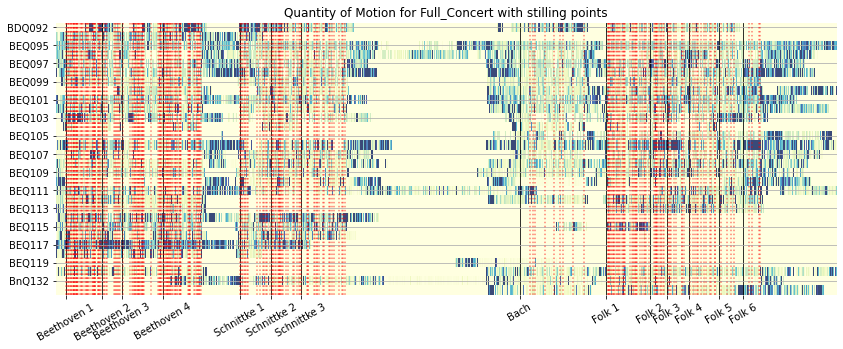

In [24]:
fig, (ax1) = plt.subplots(1, 1,figsize = [14,5])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.8)
new_xticks = len(seg_df)*(Still_times.index - seg_start)/(seg_end-seg_start)

for i in range(len(new_xticks)):
    ax1.plot([new_xticks[i],new_xticks[i]],[0,90],':r',alpha=0.5)

ax1.set_title('Quantity of Motion for ' + seg_tag + ' with stilling points')
Music_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end-seg_start)
ax1.set_xticks(Music_xticks)
ax1.set_xticklabels(seg_times.Event)
ax1.tick_params(axis='x',grid_color='k',labelrotation=30)
ax1.grid()

plt.savefig('./Stillness_Plots/V_qom_stillingpoints.png',dpi = 300)
#plt.savefig('./Stillness_Plots/Hall_qom_stillingpoints.png',dpi = 300)
plt.show()

In [47]:
# seg_tag = '22 s in Beethoven'
# seg_start = 219.3 #Main_concert_times.iloc[33,0]
# seg_end = 241.6 # Main_concert_times.iloc[34,0]
seg_tag = '30 s in Folk Music section' #120s in Folk Music section
seg_start = 6650.0 #Main_concert_times.iloc[33,0]
seg_end = 6680.0 # Main_concert_times.iloc[34,0]
seg_qom = seg_df.loc[seg_start:seg_end].copy()
Still_times  = Stillings.loc[seg_start:seg_end].copy()
seg_sound = reSound.loc[seg_start:seg_end].copy()
[seg_start,seg_end ]

[6650.0, 6680.0]

In [85]:
seg_tag = 'Folk 1'
seg_start = 6614.83+5 #Main_concert_times.iloc[33,0]
seg_end = seg_start+5 + 120 # Main_concert_times.iloc[34,0]
seg_qom = seg_df.loc[seg_start:seg_end].copy()
Still_times  = Stillings.loc[seg_start:seg_end].copy()
seg_sound = reSound.loc[seg_start:seg_end].copy()
[seg_start,seg_end ]

[6619.83, 6744.83]

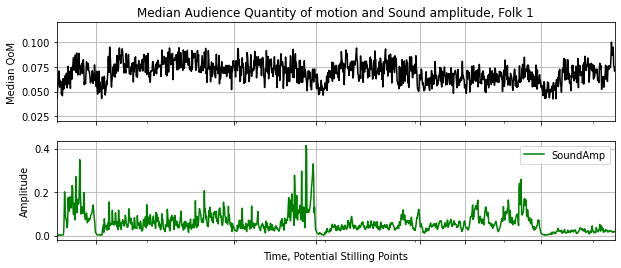

In [86]:

fig, (ax1,ax2) = plt.subplots(2, 1,sharex = True,figsize = [10,4])
seg_df.median(axis=1).plot(ax=ax1,label='Median',color='k')
#ax1.set_xticks(Still_times.index)
#ax1.set_xticklabels(Still_times.LABEL, rotation='45',fontsize=8, ha='right')
#ax1.set_xlim([seg_start,seg_end])
ax1.set_title('Median Audience Quantity of motion and Sound amplitude, ' + seg_tag)
ax1.set_ylim([0.02,0.12])
ax1.set_ylabel('Median QoM')
ax1.grid()

seg_sound.plot(ax=ax2,color='g')
ax2.set_xticks(Still_times.index)
a = ax2.get_xticklabels()
ax2.set_xticklabels(a,rotation='45',fontsize=8, ha='right')
ax2.set_xlim([seg_start,seg_end])
ax2.set_xlabel('Time, Potential Stilling Points')
ax2.set_ylabel('Amplitude')
ax2.grid()

#plt.savefig('./Stillness_Plots/mQoM_Sound_excerpt2.png',dpi = 300)
plt.show()

In [71]:
seg_tag = '20 s in Beethoven'
seg_start = 218.0 #Main_concert_times.iloc[33,0]
seg_end = 238.0 # Main_concert_times.iloc[34,0]
seg_qom = seg_df.loc[seg_start:seg_end].copy()
Still_times  = Stillings.loc[seg_start:seg_end].copy()
seg_sound = reSound.loc[seg_start:seg_end].copy()
[seg_start,seg_end ]

[218.0, 238.0]

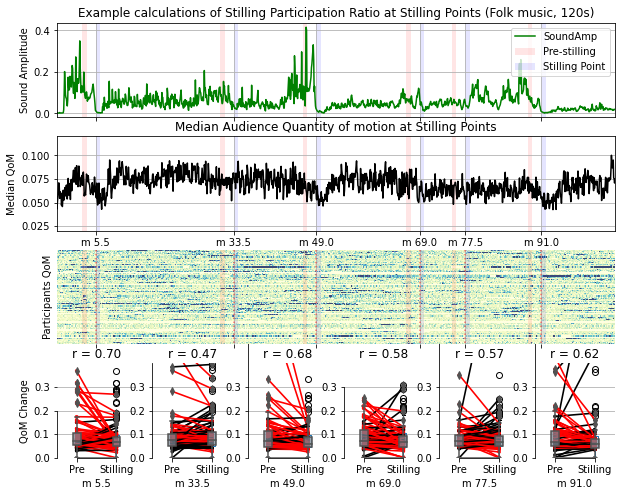

In [259]:
seg_tag = 'Folk 1'
seg_start = 6614.83+5 #Main_concert_times.iloc[33,0]
seg_end = seg_start+5 + 120 # Main_concert_times.iloc[34,0]
seg_qom = seg_df.loc[seg_start:seg_end].copy()
Still_times  = Stillings.loc[seg_start:seg_end].copy()
Still_times['LABEL'] = [ 'm 5.5', 'm 33.5', 'm 49.0', 'm 69.0', 'm 77.5', 'm 91.0']

seg_sound = reSound.loc[seg_start:seg_end].copy()
[seg_start,seg_end ]

fig, axs = plt.subplots(ncols=len(Still_times), nrows=4,figsize = [10,8])
gs = axs[0, 1].get_gridspec()

for ax in axs[0, :]: ax.remove()
axbig = fig.add_subplot(gs[0, :])
seg_sound.plot(ax=axbig,color='g')
axbig.set_xticks(Still_times.index)
axbig.set_xticklabels([])
axbig.set_xlim([seg_start,seg_end])
#axbig.set_xlabel('Time, Potential Stilling Points')
axbig.set_ylabel('Sound Amplitude')
axbig.set_title('Example calculations of Stilling Participation Ratio at Stilling Points (Folk music, 120s)')
axbig.grid()
yrange = [0,1]
k = 0
for ei in Still_times.index:
    if k==0:
        axbig.axvspan(ei-3, ei -2,yrange[0],yrange[1], facecolor='red', alpha=0.1,label ='Pre-stilling')
        axbig.axvspan(ei, ei + 1,yrange[0],yrange[1], facecolor='blue', alpha=0.1,label =  'Stilling Point')
        axbig.legend()
        k = 1
    else:
        axbig.axvspan(ei, ei + 1,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
        axbig.axvspan(ei-3, ei -2,yrange[0],yrange[1], facecolor='red', alpha=0.1)


for ax in axs[1, :]: ax.remove()
axbig = fig.add_subplot(gs[1, :])
seg_df.median(axis=1).plot(ax=axbig,label='Median',color='k')
axbig.set_title('Median Audience Quantity of motion at Stilling Points')
axbig.set_ylim([0.02,0.12])
axbig.set_xlim([seg_start,seg_end])
axbig.set_xticks(Still_times.index)
axbig.set_xticklabels(Still_times.LABEL)
axbig.set_ylabel('Median QoM')
axbig.grid()

yrange = [0,1]
for ei in Still_times.index:
    axbig.axvspan(ei, ei + 1,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    axbig.axvspan(ei-3, ei -2,yrange[0],yrange[1], facecolor='red', alpha=0.1)

for ax in axs[2, :]: ax.remove()
axbig = fig.add_subplot(gs[2, :])
yrange = [0,90]
chart = sns.heatmap(data=seg_qom.transpose(), ax=axbig,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.8)
new_xticks = len(seg_qom)*(Still_times.index - seg_start)/(seg_end-seg_start)
a = Still_times.index.append(Still_times.index+1)
a = a.append(a-3).sort_values()
cue_ticks = len(seg_qom)*(a - seg_start)/(seg_end-seg_start)
for i in range(len(new_xticks)):
    axbig.plot([new_xticks[i],new_xticks[i]],yrange,':r',alpha=0.5)
    axbig.axvspan(cue_ticks[(i*4)+2], cue_ticks[(i*4)+3],yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    axbig.axvspan(cue_ticks[(i*4)+0], cue_ticks[(i*4)+1],yrange[0],yrange[1], facecolor='red', alpha=0.1)
#axbig.set_title('Quantity of Motion per participant at Stilling points')
#axbig.set_xlabel('Time, (s) with mm')
axbig.set_ylabel('Participants QoM')
axbig.set_yticks([])
axbig.set_xticks(new_xticks)
axbig.set_xticklabels([])
#axbig.tick_params(axis='x',grid_color='k',labelrotation=30)
axbig.grid()
yrange = [0,80]
i = 0

for i in range(len(Still_times.index)):
    ei = Still_times.index[i]
    m1 = pd.DataFrame(columns=['PartID','Cond','QoM'])
    m1['PartID'] = seg_qom.columns
    m2 = m1.copy()
    m1['Cond']  = 'Pre'
    m1['QoM'] = seg_qom.loc[ei-3:ei-2].mean().values
    m2['Cond']  = 'Stilling'
    m2['QoM'] =  seg_qom.loc[ei:ei + 1].mean().values
    mQoM = pd.concat([m1,m2])
    mQoM.boxplot(ax = axs[3,i])
    pg.plot_paired(data=mQoM, dv='QoM', within='Cond',
                    subject='PartID', ax=axs[3,i], boxplot_in_front=True,
               colors=['black', 'grey', 'red'])
    axs[3,i].set_ylim([0,0.4])
    axs[3,i].set_yticks([0,0.1,0.2,0.3])
    axs[3,i].set_ylabel('')
    axs[3,i].set_xlabel(Still_times.iloc[i,0])
    a = m2['QoM']-m1['QoM']
    r = (a<0).sum()/((a<0).sum()+(a>0).sum())
    axs[3,i].set_title('r = ' + f'{r:.2f}')
axs[3,0].set_ylabel('QoM Change')
#fig.tight_layout()
#plt.savefig('./Stillness_Plots/V_mQoM_PreStilling_examples.png',dpi = 300)
plt.savefig('./Stillness_Plots/mQoM_PreStilling_examples.png',bbox_inches = 'tight',dpi = 300)

plt.show()


## Analysis 1: Distribution of decrease, Still and Stiller
    Distribution of decreases across all music and across stilling points
    Still vs stiller points
    Median median time series at these stiller points, timing argument across all points


In [266]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[53,0]
seg_times = Main_concert_times.loc[Main_concert_times['Event_Type'].isin(['Music']),:]
[seg_start,seg_end ]
seg_df = aud_df.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)
Still_times  = Stillings.loc[seg_start:seg_end].copy()


In [267]:
preoff = -3
postoff = 0

In [270]:
# decreases for all music
V_df = pd.DataFrame(index = music_index)
seg_df = aud_df.copy()
#seg_df = seg_df.fillna(0)
k=[]
qm1 = []
qm2 = []
for i in music_index:
    pre_snip_df = seg_df.loc[i+preoff:i+preoff+1.0].mean(axis=0).values
    post_snip_df = seg_df.loc[i++postoff:i++postoff+1].mean(axis=0).values
    Se=post_snip_df - pre_snip_df
    k.append((Se<0).sum()/((Se<0).sum()+(Se>0).sum()))
    qm1.append(np.nanmedian(pre_snip_df))
    qm2.append(np.nanmedian(post_snip_df))
V_df['Ratio'] = k
V_df['QoM-pre'] = qm1
V_df['QoM-post'] = qm2
print([np.median(np.array(k)),np.std(np.array(k))])

[0.5068493150684932, 0.06838747503602431]


In [275]:
V_df.to_csv('Music_Index_qom_pre_stillings.csv')

In [272]:
np.nanmedian(pre_snip_df)

0.09681408352844269

In [273]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[51,0]
[seg_start,seg_end ]
Still_times  = Stillings.loc[seg_start:seg_end].copy()

#fig,ax = plt.subplots(1,1,figsize=[14,4] )
V = pd.DataFrame(columns = seg_df.columns)
k = []
for i in range(len(Still_times)):
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    pre_snip_df = seg_df.loc[Otime+preoff:Otime+preoff+1.0].mean(axis=0).values
    post_snip_df = seg_df.loc[Otime+postoff:Otime+postoff+1.0].mean(axis=0).values
    Se=post_snip_df - pre_snip_df
    V.loc[Otime,:] = Se
    k.append((Se<0).sum()/((Se<0).sum()+(Se>0).sum()))
Still_times['Ratio'] = k
print([np.median(np.array(k)),np.std(np.array(k))])

[0.5432098765432098, 0.08116458798492059]


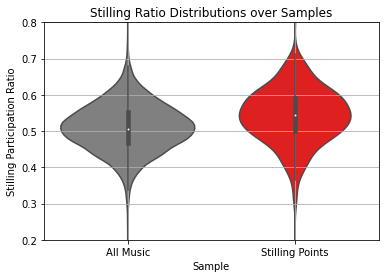

In [276]:
A = V_df.loc[:,['Ratio']].copy()
A['Sample'] = 'All Music'
B = Still_times.loc[:,['Ratio']].copy()
B.loc[:,'Sample'] = 'Stilling Points'
df = pd.concat([A,B],axis = 0)

cpalette = {'All Music':'grey','Stilling Points':'r'}

sns.violinplot(data=df, x="Sample", y="Ratio",palette = cpalette,figsize=[6,5])
plt.title('Stilling Ratio Distributions over Samples')
plt.ylabel('Stilling Participation Ratio')
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
#Part_Still.loc[:,'Ratio'].plot.kde()
#plt.xlim([0,1])
plt.ylim([0.2,0.8])

#plt.savefig('./Stillness_Plots/V_All_Music_part_ratios_violin.png',dpi = 300)
plt.savefig('./Stillness_Plots/All_Music_part_ratios_violin.png',bbox_inches = 'tight',dpi = 300)

plt.show()

In [277]:
print([Still_times.loc[:,'Ratio'].median(),V_df.loc[:,'Ratio'].median()])
sp.stats.ks_2samp(Still_times.loc[:,'Ratio'], V_df.loc[:,'Ratio'], alternative='less')
#sp.stats.ks_2samp(Still_times.loc[:,'Ratio'], V_df.loc[music_index[np.arange(1,50630,40)],'Ratio'], alternative='less')

[0.5432098765432098, 0.5068493150684932]


KstestResult(statistic=0.21561507880088315, pvalue=4.091292492051354e-11)

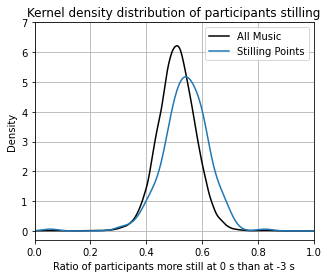

In [278]:
V_df.loc[:,'Ratio'].plot.kde(label='All Music',color='k',figsize=[5,4])
Still_times.loc[:,'Ratio'].plot.kde(label='Stilling Points')
plt.legend()
plt.title('Kernel density distribution of participants stilling')
plt.xlabel('Ratio of participants more still at 0 s than at -3 s')
plt.grid()
#Part_Still.loc[:,'Ratio'].plot.kde()
plt.xlim([0,1])
plt.ylim([-0.3,7])
plt.savefig('./Plots/All_Stillings_part_ratios_dke.png',dpi = 300)
#plt.savefig('./Stillness_Plots/V_All_Music_part_ratios_dke.png',dpi = 300)

plt.show()

<AxesSubplot:xlabel='Ratio', ylabel='QoMmedian_pre'>

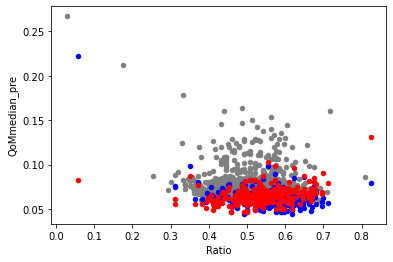

In [279]:
ax = V_df.loc[music_index[np.arange(1,50630,40)],:].plot.scatter(y = 'QoM-post',x = 'Ratio',c = 'grey')
Still_times.plot.scatter(y = 'QoMmedian_post',x = 'Ratio',c = "blue",ax = ax)
Still_times.plot.scatter(y = 'QoMmedian_pre',x = 'Ratio',c = "red",ax = ax)

<AxesSubplot:xlabel='Ratio', ylabel='SoundAmp_shift'>

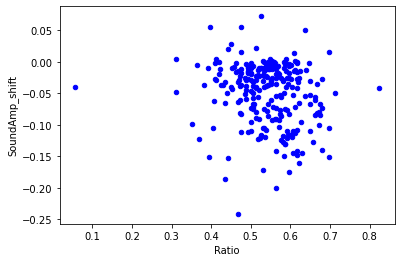

In [280]:
Still_times.plot.scatter(y = 'SoundAmp_shift',x = 'Ratio',c = "blue") #'SoundAmp_post', 'SoundAmp_shift'

In [281]:
sum(V_df.loc[:,'Ratio']<Still_times.loc[:,'Ratio'].median())/len(V_df.loc[:,'Ratio'])

0.6963657910329843

The likelihood of a participant decreasing in their movements at stilling points is greater than any random point in the music. 50% of stilling points feature more motion decreases than 70% of time music is being presented. That's not a huge difference, but it's robust, suggesting there is something about these stilling points that are more encouraging of stillness than any given moment of music. 

These stilling points are not forcing cooperative changes in motion in across the entire audience. These shifts in quantity of motion are small and the ratios suggest that around the constant noise of some moving more and some moving less, only a small subset can be assumed to be shifting behaviour in response to whatever makes a "stilling" point. 

Since this much has been demonstrated, that there is something about stilling points that encourage (lightly) the audience to be more still in aggregage, we can turn the data around to see if there are any particular qualities or differences between those points that are more influential vs less. Those points with higher than median participation are here refered to as "stiller" points. 

### Stiller points
Let's allow that my definition of stilling points is flawed, including moments that maybe do not have the impact hypothesised. From the measured response pattern we can define a subset of points that show the expected effect, the "stiller points" with a majority of participants decreasing in motion into these moments. 

We still can not assume everyone is responding to the musical qualities that prompted the moment to be selected in the initial stilling point assessment, but it does give a subset of moments with some likely shared influence on how the audience behaved. Comparing stilling points to stiller points may illucidate the phenomenon of interest. 


In [282]:
thresh = V_df.loc[:,'Ratio'].median() # median of stilling ratio across whole intervals of recording
Part_Still = Still_times.loc[Still_times['Ratio']>thresh,:]

Part_UnStill = Still_times.loc[Still_times['Ratio']<=thresh,:]
# other exclusion criteria
# mean_dec = 0.47058823529411764 #V_df ,mean
# Part_Still = Still_times.loc[Still_times['Ratio']>mean_dec,:]
# Part_Still = Still_times.loc[~Still_times['LABEL'].isin(['e']),:] # in person hall participant
# Part_Still = Part_Still.loc[Part_Still['Ratio']>mean_dec,:]
#Part_Still = Part_Still.loc[~Part_Still['LABEL'].isin(['e-1']),:] # in person hall participant
#Part_Still = Part_Still.loc[Part_Still['Gap']>0,:].reset_index(drop = True) # with aligned motion measurements
print([len(Part_Still),len(Part_Still)/len(Still_times), Part_Still['Ratio'].mean()])
print([len(Part_UnStill),len(Part_UnStill)/len(Still_times), Part_UnStill['Ratio'].mean()])

[174, 0.6770428015564203, 0.5819943983901174]
[83, 0.3229571984435798, 0.4542713041916231]


In [292]:
Stills_Pieces = pd.DataFrame()
Stills_Pieces['Stilling'] =Still_times['Music'].value_counts()
Stills_Pieces['Stiller'] = Part_Still['Music'].value_counts()
Stills_Pieces['R_stilled'] = Stills_Pieces.loc[:,"Stiller"]/Stills_Pieces.loc[:,"Stilling"]
Stills_Pieces

,Stilling,Stiller,R_stilled
Beethoven,120,83,0.691667
Folk,74,47,0.635135
Schnittke,54,37,0.685185
Bach,9,7,0.777778


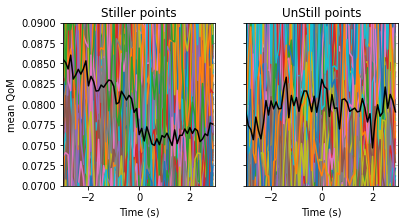

In [293]:
# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.mean(axis=1,skipna = True)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_times.index)
snips2 = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_UnStill.index)
for i in range(len(Part_Still)-1):
    sm = Part_Still.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
    
for i in range(len(Part_UnStill)-1):
    sm = Part_UnStill.iloc[i,:]
    Otime = sm.name
    snips2.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
        
f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))
yrange = [0.070,0.090]
xrange = [-3,3]
ax=ax1
snips.plot(legend = False,ax=ax)
snips.median(axis=1).plot(color = 'k',legend = False,ax=ax)
ax.set_title('Stiller points')
ax.set_ylim(yrange)
ax.set_xlim(xrange)
ax.set_ylabel('mean QoM')
ax.set_xlabel('Time (s)')
ax.grid()

ax=ax2
snips2.plot(legend = False,ax=ax)
snips2.median(axis=1).plot(color = 'k',legend = False,ax=ax)
ax.set_title('UnStill points')
ax.set_yticklabels([])
ax.set_ylim(yrange)
ax.set_xlim(xrange)
ax.set_xlabel('Time (s)')
ax.grid()


plt.savefig('./Stillness_Plots/Stiller_QoM_Means_with_ends.png',bbox_inches = 'tight',dpi = 300)

plt.show()


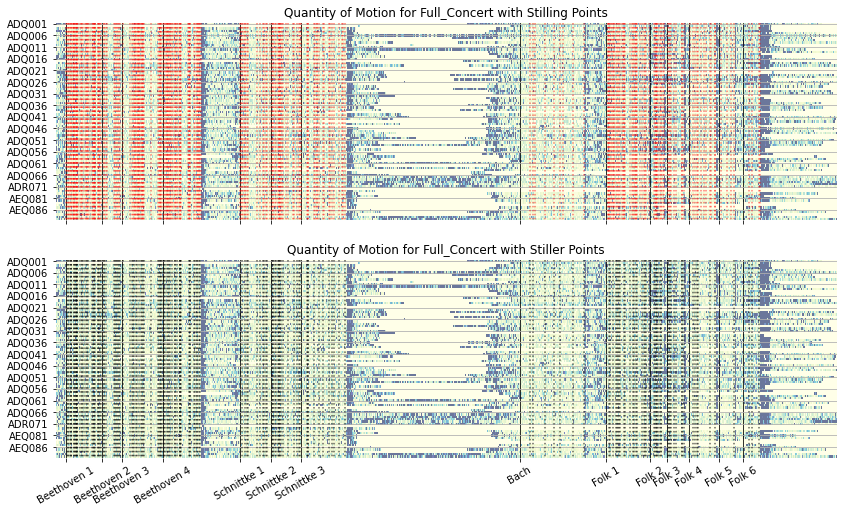

In [286]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[53,0]
seg_times = Main_concert_times.loc[Main_concert_times['Event_Type'].isin(['Music']),:]
[seg_start,seg_end ]
seg_df = aud_df.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)

fig, (ax1,ax2) = plt.subplots(2, 1,figsize = [14,8])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.6)
new_xticks = len(seg_df)*(Still_times.index - seg_start)/(seg_end-seg_start)
#ax1.set_xticks(new_xticks)

for i in range(len(new_xticks)):
    ax1.plot([new_xticks[i],new_xticks[i]],[0,90],':r',alpha=0.5)

ax1.set_title('Quantity of Motion for ' + seg_tag + ' with Stilling Points')
Music_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end-seg_start)
ax1.set_xticks(Music_xticks)
ax1.set_xticklabels([])
ax1.tick_params(axis='x',grid_color='k',labelrotation=30)
ax1.grid()


chart = sns.heatmap(data=seg_df.transpose(), ax=ax2,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.6)

# new_xticks = len(seg_df)*(Mixed_Still.index - seg_start)/(seg_end-seg_start)
# for i in range(len(new_xticks)):
#     ax2.plot([new_xticks[i],new_xticks[i]],[0,90],':r',alpha=0.5)
    
new_xticks = len(seg_df)*(Part_times.index - seg_start)/(seg_end-seg_start)
for i in range(len(new_xticks)):
    ax2.plot([new_xticks[i],new_xticks[i]],[0,90],':k',alpha=0.6)

ax2.set_title('Quantity of Motion for ' + seg_tag + ' with Stiller Points')
#ax2.set_title('Quantity of Motion for ' + seg_tag + ' with stiller and Low-low points')
ax2.set_xticks(Music_xticks)
ax2.set_xticklabels(seg_times.Event)
ax2.tick_params(axis='x',grid_color='k',labelrotation=30)
ax2.grid()
plt.savefig('./Stillness_Plots/Hall_qom_More_stilledpoints.png',dpi = 300)
#plt.savefig('./Plots/Hall_qom_Mixed_stillpoints.png',dpi = 300)
plt.show()

In [294]:
tags_bi = ['Gap', 'Rest', 'Connect',
       'Voices_dec', 'Note_rate_dec', 'Drone', 'TextInc', 'Phr_end',
       'Phr_begining', 'Elide', 'Sequence', 'Rubato', 'Rit', 'Fermata',
       'Tempo_inc', 'Diminuendo', 'Fp/Fz', 'Cresc', 'Precision', 'end']

tags_all = ['cues', 'Type', 'Gap', 'Rest', 'Connect',
       'Voices_dec', 'Note_rate_dec', 'Drone', 'TextInc', 'Phr_end',
       'Phr_begining', 'Elide', 'Sequence', 'Rubato', 'Rit', 'Fermata',
       'Tempo_inc', 'Diminuendo', 'Fp/Fz', 'Cresc', 'Precision', 'end',
       'OLDTIME', 'Ratio', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
       'OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift', 'QoMmean_pre',
       'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post',
       'QoMmedian_shift', 'Music']

tags_quant = ['cues','Ratio', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
       'OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift', 'QoMmean_pre',
       'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post',
       'QoMmedian_shift']

tags_cat = ['LABEL','Set','Movement','Type','Music']

Feat_stats = pd.DataFrame(index = Part_Still.columns)

A = Still_times[tags_bi].sum()
Feat_stats.loc[A.index,"All Stillings"] = A

A = Still_times[tags_quant].mean()
Feat_stats.loc[A.index,"All Stillings"] = A

A = Part_Still[tags_bi].sum()
Feat_stats.loc[A.index,"Stillers"] = A

A = Part_Still[tags_quant].mean()
Feat_stats.loc[A.index,"Stillers"] = A

A = Part_UnStill[tags_bi].sum()
Feat_stats.loc[A.index,"UnStills"] = A

A = Part_UnStill[tags_quant].mean()
Feat_stats.loc[A.index,"UnStills"] = A

# A = Mixed_Still[['end','Sequence', 'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
#        'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
#        'Diminuendo', 'TextDec', 'Drone', 'TextInc', 'revisedT']].sum()
# Feat_stats.loc[A.index,"Mixed"] = A

# A = Mixed_Still[['old_Ratio', 'Ratio', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
#        'OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift', 'QoMmean_pre',
#        'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post',
#        'QoMmedian_shift']].mean()
# Feat_stats.loc[A.index,"Mixed"] = A
Feat_stats['R_stilled'] = Feat_stats.loc[:,"Stillers"]/Feat_stats.loc[:,"All Stillings"]
# Feat_stats['R_Mixed'] = Feat_stats.loc[:,"Mixed"]/Feat_stats.loc[:,"Stillings"]

In [295]:
Feat_stats

,All Stillings,Stillers,UnStills,R_stilled
LABEL,NaN,NaN,NaN,NaN
Set,NaN,NaN,NaN,NaN
Movement,NaN,NaN,NaN,NaN
cues,1.070039,1.057471,1.096386,0.988255
Type,NaN,NaN,NaN,NaN
Gap,136.000000,96.000000,40.000000,0.705882
Rest,95.000000,68.000000,27.000000,0.715789
Connect,122.000000,78.000000,44.000000,0.639344
Voices_dec,130.000000,84.000000,46.000000,0.646154
Note_rate_dec,57.000000,40.000000,17.000000,0.701754


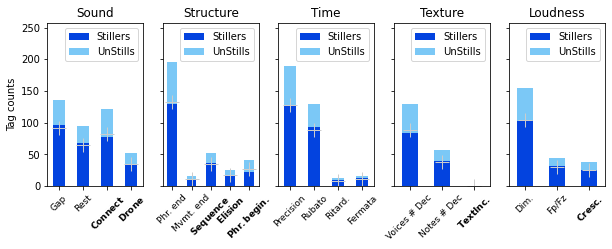

In [296]:
feats_sound = ['Gap', 'Rest', 'Connect', 'Drone',]
feats_texture = ['Voices_dec', 'Note_rate_dec','TextInc',]
feats_structure = ['Phr_end','end','Sequence', 'Elide','Phr_begining', ]
feats_tempo = ['Precision','Rubato', 'Rit', 'Fermata',]
feats_loudness = ['Diminuendo', 'Fp/Fz', 'Cresc',]
feats_ampli = ['SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',]
feats_qom = ['QoMmean_pre','QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post','QoMmedian_shift','Ratio']

marker_style = dict(linestyle='', color='0.8', markersize=14,)
width = 0.5

f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(10,3))
ax = ax1
feats_set = feats_sound
feats_subtag = ['Gap','Rest',"$\\bf{Connect}$","$\\bf{Drone}$"]
ax.bar(feats_set,Feat_stats.loc[feats_set,"Stillers"], width,label="Stillers",color='xkcd:blue')
ax.bar(feats_set,Feat_stats.loc[feats_set,"UnStills"], width,bottom=Feat_stats.loc[feats_set,"Stillers"],label="UnStills",color='xkcd:lightblue')
ax.plot(Feat_stats.loc[feats_set,"All Stillings"]*0.677, marker='+', **marker_style)
ax.set_xticks(np.arange(len(feats_set)))
ax.set_xticklabels(feats_subtag,fontsize=9)
ax.set_title('Sound')
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,len(Still_times)])
ax.legend(loc="best")
ax.set_ylabel('Tag counts')
ax.tick_params(axis='x',labelrotation=45)

ax = ax2
feats_set = feats_structure
feats_subtag = ['Phr. end',"Mvmt. end","$\\bf{Sequence}$","$\\bf{Elision}$","$\\bf{Phr. begin.}$"]
ax.bar(feats_set,Feat_stats.loc[feats_set,"Stillers"], width,label="Stillers",color='xkcd:blue')
ax.bar(feats_set,Feat_stats.loc[feats_set,"UnStills"], width,bottom=Feat_stats.loc[feats_set,"Stillers"],label="UnStills",color='xkcd:lightblue')
ax.plot(Feat_stats.loc[feats_set,"All Stillings"]*0.677, marker='+', **marker_style)
ax.set_xticks(np.arange(len(feats_set)))
ax.set_xticklabels(feats_subtag)
ax.set_title('Structure')
ax.legend(loc="best")
ax.set_yticklabels([])
ax.set_xticklabels(feats_subtag,fontsize=9)
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,len(Still_times)])
ax.tick_params(axis='x',labelrotation=45)

ax = ax3
feats_set = feats_tempo
feats_subtag = ['Precision','Rubato', 'Ritard.', 'Fermata', ]
ax.bar(feats_set,Feat_stats.loc[feats_set,"Stillers"], width,label="Stillers",color='xkcd:blue')
ax.bar(feats_set,Feat_stats.loc[feats_set,"UnStills"], width,bottom=Feat_stats.loc[feats_set,"Stillers"],label="UnStills",color='xkcd:lightblue')
ax.plot(Feat_stats.loc[feats_set,"All Stillings"]*0.677, marker='+', **marker_style)
ax.set_xticks(np.arange(len(feats_set)))
ax.set_xticklabels(feats_subtag)
ax.set_title('Time')
ax.legend(loc="best")
ax.set_yticklabels([])
ax.set_xticklabels(feats_subtag,fontsize=9)
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,len(Still_times)])
ax.tick_params(axis='x',labelrotation=45)

ax = ax4
feats_set = feats_texture
feats_subtag =['Voices # Dec', 'Notes # Dec',"$\\bf{Text Inc.}$",]
ax.bar(feats_set,Feat_stats.loc[feats_set,"Stillers"], width,label="Stillers",color='xkcd:blue')
ax.bar(feats_set,Feat_stats.loc[feats_set,"UnStills"], width,bottom=Feat_stats.loc[feats_set,"Stillers"],label="UnStills",color='xkcd:lightblue')
ax.plot(Feat_stats.loc[feats_set,"All Stillings"]*0.677, marker='+', **marker_style)
ax.set_xticks(np.arange(len(feats_set)))
ax.set_xticklabels(feats_subtag)
ax.set_title('Texture') 
ax.legend(loc="best")
ax.set_yticklabels([])
ax.set_xticklabels(feats_subtag,fontsize=9)
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,len(Still_times)])
ax.tick_params(axis='x',labelrotation=45)

ax = ax5
feats_set = feats_loudness
feats_subtag = ['Dim.', 'Fp/Fz', "$\\bf{Cresc.}$",]
ax.bar(feats_set,Feat_stats.loc[feats_set,"Stillers"], width,label="Stillers",color='xkcd:blue')
ax.bar(feats_set,Feat_stats.loc[feats_set,"UnStills"], width,bottom=Feat_stats.loc[feats_set,"Stillers"],label="UnStills",color='xkcd:lightblue')
ax.plot(Feat_stats.loc[feats_set,"All Stillings"]*0.677, marker='+', **marker_style)
ax.set_xticks(np.arange(len(feats_set)))
ax.set_yticklabels([])
ax.set_xticklabels(feats_subtag,fontsize=9)
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,len(Still_times)])
ax.set_title('Loudness') 
ax.legend(loc="best")
ax.tick_params(axis='x',labelrotation=45)

plt.savefig('./Stillness_Plots/Tags_Stiller_Ratio_sep.png', bbox_inches = 'tight',dpi = 300)

plt.show()

## Analysis 2: Stiller and the lower limit of measurable motion 

    stiller vs less still points per tag/feature
    mQoM pre and at still points for all stilling, stiller, and less still points
    What proportion of music listening is under this threshold?
    Full concert motion with stiller points and min motion points.


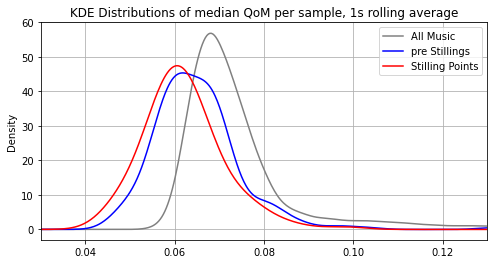

In [297]:
#medianQM = mus_df.median(axis=1)
medianQM_Roll = mus_df.rolling(10).mean().median(axis=1)
f, ax = plt.subplots(1,1,figsize=[8,4])
#medianQM.plot.kde(label='All Music_rough',ax=ax)
medianQM_Roll.plot.kde(label='All Music',color='grey',ax=ax)
Still_times.loc[:,'QoMmedian_pre'].plot.kde(label='pre Stillings',color='blue',ax=ax)
Still_times.loc[:,'QoMmedian_post'].plot.kde(label='Stilling Points',color='red',ax=ax)

plt.legend()
plt.title('KDE Distributions of median QoM per sample, 1s rolling average')
plt.grid()
plt.xlim([0.03,0.13])
plt.ylim([-3,60])
#plt.savefig('./Plots/All_Stillings_medQoM_dke.png',dpi = 300)

plt.show()

In [298]:
len(mus_df.columns)

85

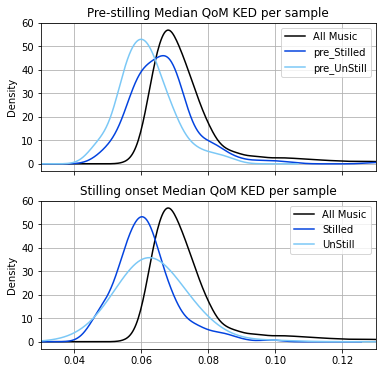

In [299]:
Part_times = Part_Still.copy()
medianQM_Roll = mus_df.rolling(10).mean().median(axis=1)
f, (ax1,ax2) = plt.subplots(2,1,figsize=[6,6])

ax = ax1
medianQM_Roll.plot.kde(label='All Music',color='black',ax=ax)
Part_times.loc[:,'QoMmedian_pre'].plot.kde(label='pre_Stilled',color='xkcd:blue',ax=ax)
Part_UnStill.loc[:,'QoMmedian_pre'].plot.kde(label='pre_UnStill',color='xkcd:lightblue',ax=ax)
ax.legend()
ax.set_title('Pre-stilling Median QoM KED per sample')
ax.set_xticklabels([])
ax.grid()
ax.set_xlim([0.03,0.13])
ax.set_ylim([-3,60])

ax = ax2
medianQM_Roll.plot.kde(label='All Music',color='black',ax=ax)
Part_times.loc[:,'QoMmedian_post'].plot.kde(label='Stilled',color='xkcd:blue',ax=ax)
Part_UnStill.loc[:,'QoMmedian_post'].plot.kde(label='UnStill',color='xkcd:lightblue',ax=ax)
ax.legend()
ax.set_title('Stilling onset Median QoM KED per sample')
ax.grid()
ax.set_xlim([0.03,0.13])
ax.set_ylim([-3,60])

plt.savefig('./Stillness_Plots/All_Stillings_Stillers_medQoM_dke.png',bbox_inches = 'tight',dpi = 300)

plt.show()

In [300]:
Already_still_Thresh = Part_times.loc[:,'QoMmedian_post'].median()
Already_still_Thresh 

0.06023025456318375

In [306]:
(Part_UnStill.loc[:,'QoMmedian_pre']<=Already_still_Thresh).sum()

38

In [301]:
(Part_UnStill.loc[:,'QoMmedian_pre']<=Already_still_Thresh).sum()/len(Part_UnStill)

0.4578313253012048

In [302]:
(Part_Still.loc[:,'QoMmedian_pre']<=Already_still_Thresh).sum()/len(Part_Still)

0.27586206896551724

In [303]:
(len(Part_Still)+(Part_UnStill.loc[:,'QoMmedian_pre']<=Already_still_Thresh).sum())/len(Still_times)

0.8249027237354085

In [304]:
medianQM_Roll.loc[medianQM_Roll<Already_still_Thresh].index

Float64Index([ 181.9,  183.6,  183.7,  183.8,  183.9,  184.0,  184.2,  184.3,
               184.4,  184.5,
              ...
              7535.3, 7535.4, 7535.5, 7535.6, 7728.2, 7730.2, 7730.9, 7731.8,
              7731.9, 7732.1],
             dtype='float64', length=1226)

In [305]:
len(medianQM_Roll.loc[medianQM_Roll<Already_still_Thresh].index)/len(medianQM_Roll)

0.024214892356310486

In [207]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[53,0]
seg_times = Main_concert_times.loc[Main_concert_times['Event_Type'].isin(['Music']),:]
[seg_start,seg_end ]
seg_df = aud_df.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)


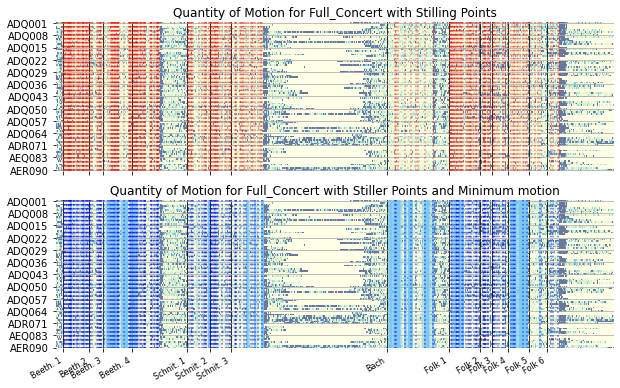

In [230]:

fig, (ax1,ax2) = plt.subplots(2, 1,figsize = [10,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.6)
new_xticks = len(seg_df)*(Still_times.index - seg_start)/(seg_end-seg_start)
#ax1.set_xticks(new_xticks)

for i in range(len(new_xticks)):
    ax1.plot([new_xticks[i],new_xticks[i]],[0,90],':r',alpha=0.5)

ax1.set_title('Quantity of Motion for ' + seg_tag + ' with Stilling Points')
Music_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end-seg_start)
ax1.set_xticks(Music_xticks)
ax1.set_xticklabels([])
ax1.tick_params(axis='x',grid_color='k',labelrotation=30)
ax1.grid()


chart = sns.heatmap(data=seg_df.transpose(), ax=ax2,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.6)

# the points already at or below the median low
new_xticks = len(seg_df)*(medianQM_Roll.loc[medianQM_Roll<Already_still_Thresh].index - seg_start)/(seg_end-seg_start)
for i in range(len(new_xticks)):
    ax2.plot([new_xticks[i],new_xticks[i]],[0,90],color='xkcd:lightblue',alpha=0.2)

# the points with significant decreases 
new_xticks = len(seg_df)*(Part_times.index - seg_start)/(seg_end-seg_start)
for i in range(len(new_xticks)):
    ax2.plot([new_xticks[i],new_xticks[i]],[0,90],':b',alpha=0.6)

ax2.set_title('Quantity of Motion for ' + seg_tag + ' with Stiller Points and Minimum motion')
#ax2.set_title('Quantity of Motion for ' + seg_tag + ' with stiller and Low-low points')
ax2.set_xticks(Music_xticks)
# 'Claps 0', 'Speech', 'Claps 1', 'Speech', 'Synch 1', 'Claps 2',
shorter_Tags = ['Beeth. 1', 'Beeth.2', 'Beeth. 3', 'Beeth. 4','Schnit. 1', 'Schnit. 2', 'Schnit. 3','Bach','Folk 1', 'Folk 2', 'Folk 3','Folk 4','Folk 5', 'Folk 6']
ax2.set_xticklabels(shorter_Tags, rotation='45',fontsize=8, ha='right') #seg_times.Event)
ax2.tick_params(axis='x',grid_color='k',labelrotation=30)
ax2.grid()
plt.savefig('./Stillness_Plots/Hall_qom_More_stilledpoints.png',bbox_inches = 'tight',dpi = 300)
#plt.savefig('./Plots/Hall_qom_Mixed_stillpoints.png',dpi = 300)
plt.show()

In [227]:
Already_still_Thresh = Part_times.loc[:,'QoMmedian_post'].median()
Stillers = Still_times.loc[Still_times['Ratio']>=0.5,:].copy()
Stilled = Still_times.loc[Still_times['Ratio']<0.5,:].copy()
Stilled = Stilled.loc[Stilled['QoMmedian_pre']<=Already_still_Thresh,:]
Stilled = Stilled.loc[Stilled['QoMmedian_post']<=Already_still_Thresh,:]
print([len(Stilled),len(Stillers)])

Still_times.loc[:,'Criterion'] = 'Select'
Stillers.loc[:,'Criterion'] = '0.5Dec'
Stilled.loc[:,'Criterion'] = 'LowLow'
Mixed_Still = pd.concat([Stillers,Stilled], axis=0).sort_index()

[16, 193]


## Analysis 3: Participation in Stillings
    Stilling participation rates: Distribution across participants per section
    Correlations across participants per section

In [231]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[53,0]
seg_times = Main_concert_times.loc[Main_concert_times['Event_Type'].isin(['Music']),:]
[seg_start,seg_end ]
seg_df = aud_df.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)


In [232]:
drop_df = aud_df.rolling(10,center=True).mean().shift(periods=0-3) - aud_df.rolling(10,center=True).mean().shift(periods=28-3) #1 second average, reported at end of window
k_df = drop_df.loc[np.round(Still_times.index,1),:].copy().fillna(0)
check=pd.DataFrame(index=k_df.index)
k_df=k_df.mask(k_df>=0, 0)
k_df=k_df.mask(k_df<0, 1)

123.52941176470588


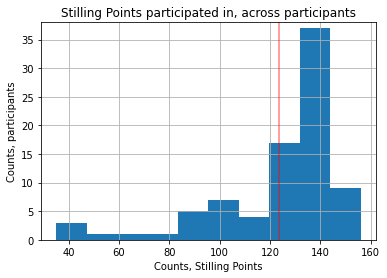

In [234]:
k_df.sum(axis=0).hist()
# if participation was random, we expect the average participation rate would be 124 
thresh = k_df.sum().sum()/len(k_df.columns)
print(thresh)
plt.plot(thresh*np.array([1.0,1.0]),[0,40],'r',alpha=0.5)
plt.title('Stilling Points participated in, across participants') 
plt.ylabel('Counts, participants')
plt.xlabel('Counts, Stilling Points')
plt.ylim([0,38])
plt.savefig('./Stillness_Plots/Stillings_Participation_Counts.png',dpi = 300)
plt.show()
# most more than half

In [235]:
# now focus on high stilling points only
k_df = drop_df.loc[np.round(Part_times.index,1),:].copy().fillna(0)
check=pd.DataFrame(index=k_df.index)
k_df=k_df.mask(k_df>=0, 0)
k_df=k_df.mask(k_df<0, 1)

88.51764705882353


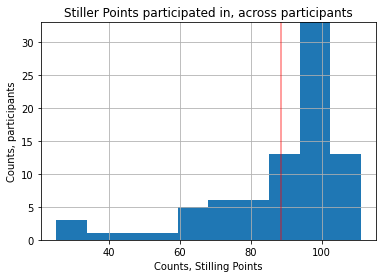

In [311]:
k_df.sum(axis=0).hist()
# if participation was random, we expect the average participation rate would be 124 
thresh = k_df.sum().sum()/len(k_df.columns)
print(thresh)
plt.plot(thresh*np.array([1.0,1.0]),[0,40],'r',alpha=0.5)
plt.title('Stiller Points participated in, across participants') 
plt.ylabel('Counts, participants')
plt.xlabel('Counts, Stilling Points')
plt.ylim([0,33])
plt.savefig('./Stillness_Plots/Stillers_Participation_Counts.png',bbox_inches = 'tight',dpi = 300)


In [317]:
k_df.sum().max()/len(Part_times)

0.6379310344827587

In [316]:
(k_df.sum()>thresh).sum()/85

0.7058823529411765

In [310]:
thresh 

0.5068493150684932

In [235]:
(31 + 25)/85

0.6588235294117647

In [239]:
co_stillings = pd.DataFrame(index = k_df.columns)
co_stillings['Full Concert']=k_df.sum(axis=0)/len(k_df)

tag = 'Beethoven'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[12,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print(len(sub_k))
co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)

tag = 'Schnittke'
seg_start = Main_concert_times.iloc[17,0]
seg_end = Main_concert_times.iloc[20,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print(len(sub_k))
co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)

tag = 'Bach'
seg_start = Main_concert_times.iloc[28,0]
seg_end = Main_concert_times.iloc[29,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print(len(sub_k))
co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)

tag = 'Folk'
seg_start = Main_concert_times.iloc[33,0]
seg_end = Main_concert_times.iloc[51,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print(len(sub_k))
co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)

co_stillings

83
37
7
47


,Full Concert,Beethoven,Schnittke,Bach,Folk
ADQ001,0.442529,0.578313,0.000000,0.714286,0.510638
ADQ002,0.183908,0.000000,0.000000,0.428571,0.617021
ADQ003,0.568966,0.590361,0.567568,0.571429,0.531915
ADQ004,0.540230,0.469880,0.486486,0.571429,0.702128
ADQ005,0.528736,0.518072,0.459459,0.857143,0.553191
...,...,...,...,...,...
AEQ086,0.172414,0.000000,0.000000,0.857143,0.510638
AEQ087,0.557471,0.518072,0.513514,0.714286,0.638298
AEQ088,0.551724,0.542169,0.540541,0.714286,0.553191
AEQ089,0.522989,0.602410,0.405405,0.428571,0.489362


In [240]:
a = co_stillings.corr()
a

,Full Concert,Beethoven,Schnittke,Bach,Folk
Full Concert,1.000000,0.758315,0.738657,0.416123,0.623144
Beethoven,0.758315,1.000000,0.537708,0.002985,0.068368
Schnittke,0.738657,0.537708,1.000000,0.220638,0.174043
Bach,0.416123,0.002985,0.220638,1.000000,0.523514
Folk,0.623144,0.068368,0.174043,0.523514,1.000000


In [241]:
sp.stats.pearsonr(co_stillings['Beethoven'], co_stillings['Schnittke'])

(0.5377081850109628, 1.117009368407562e-07)

In [242]:
sp.stats.pearsonr(co_stillings['Beethoven'], co_stillings['Bach'])

(0.002985360089420825, 0.9783670625135392)

In [243]:
sp.stats.pearsonr(co_stillings['Beethoven'], co_stillings['Folk'])

(0.06836779005100908, 0.534129142607918)

In [244]:
sp.stats.pearsonr(co_stillings['Bach'], co_stillings['Schnittke'])

(0.2206382410024792, 0.042443481554876004)

In [245]:
sp.stats.pearsonr(co_stillings['Folk'], co_stillings['Schnittke'])

(0.17404287989143585, 0.11115534060540008)

In [246]:
sp.stats.pearsonr(co_stillings['Bach'], co_stillings['Folk'])

(0.5235140824831355, 2.733618910432564e-07)